# Setting Up

First import all the necessary libaries and modules.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, Input, BatchNormalization, Activation, LeakyReLU
%matplotlib inline

In [2]:
tf.__version__

'2.1.0'

Now, set up the path to our dataset and folder where the architectural images of the models will be stored.

In [3]:
data_path = "./images/"

# Augmenting and Dividing the Images into Batches

Using Keras ImageDataGenerator, apply various augmentations to the images as they are being read from the directory, and resize them to 160x128.

In [4]:
gen = ImageDataGenerator(rotation_range=10,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.01,
                         zoom_range=[0.9, 1.25],
                         horizontal_flip=True,
                         vertical_flip=False,
                         fill_mode='reflect',
                         data_format='channels_last',
                         brightness_range=[0.7, 1.3])

img_gen = gen.flow_from_directory(data_path, target_size = (160,128), color_mode = 'rgb', classes = None, class_mode = None, batch_size = 64, shuffle = True)

Found 202599 images belonging to 1 classes.


# **Modelling the Autoencoder**

I modelled the Generator and Discriminator based on the wonderful work [Generative Adversarial Denoising Autoencoder for Face Completion](https://www.cc.gatech.edu/~hays/7476/projects/Avery_Wenchen/) by *Avery Allen, Wenchen Li*.

I used a `Denoising Autoencoder` as the Generator with `'relu'` activations in the middle layers while the output layer had a `'tanh'` activation. Each Convolution layer was followed by a `BatchNormalization` layer.

In [5]:
def make_generator():
    inp_gen = Input((160,128,3))
    x = Conv2D(256, kernel_size = (3,3), strides = (2,2), padding = 'same')(inp_gen)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1024, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    enc = Activation('relu')(x)
    x = Conv2DTranspose(512, kernel_size = (3,3), padding = 'same', strides = (2,2))(enc)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, kernel_size = (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, kernel_size = (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(3, kernel_size = (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization()(x)
    out_gen = Activation('tanh')(x)
  
    model = Model(inputs = inp_gen, outputs = out_gen)
    return model

In [6]:
generator = make_generator()

In [7]:
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 64, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 64, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 80, 64, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 32, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 32, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 32, 256)       0     

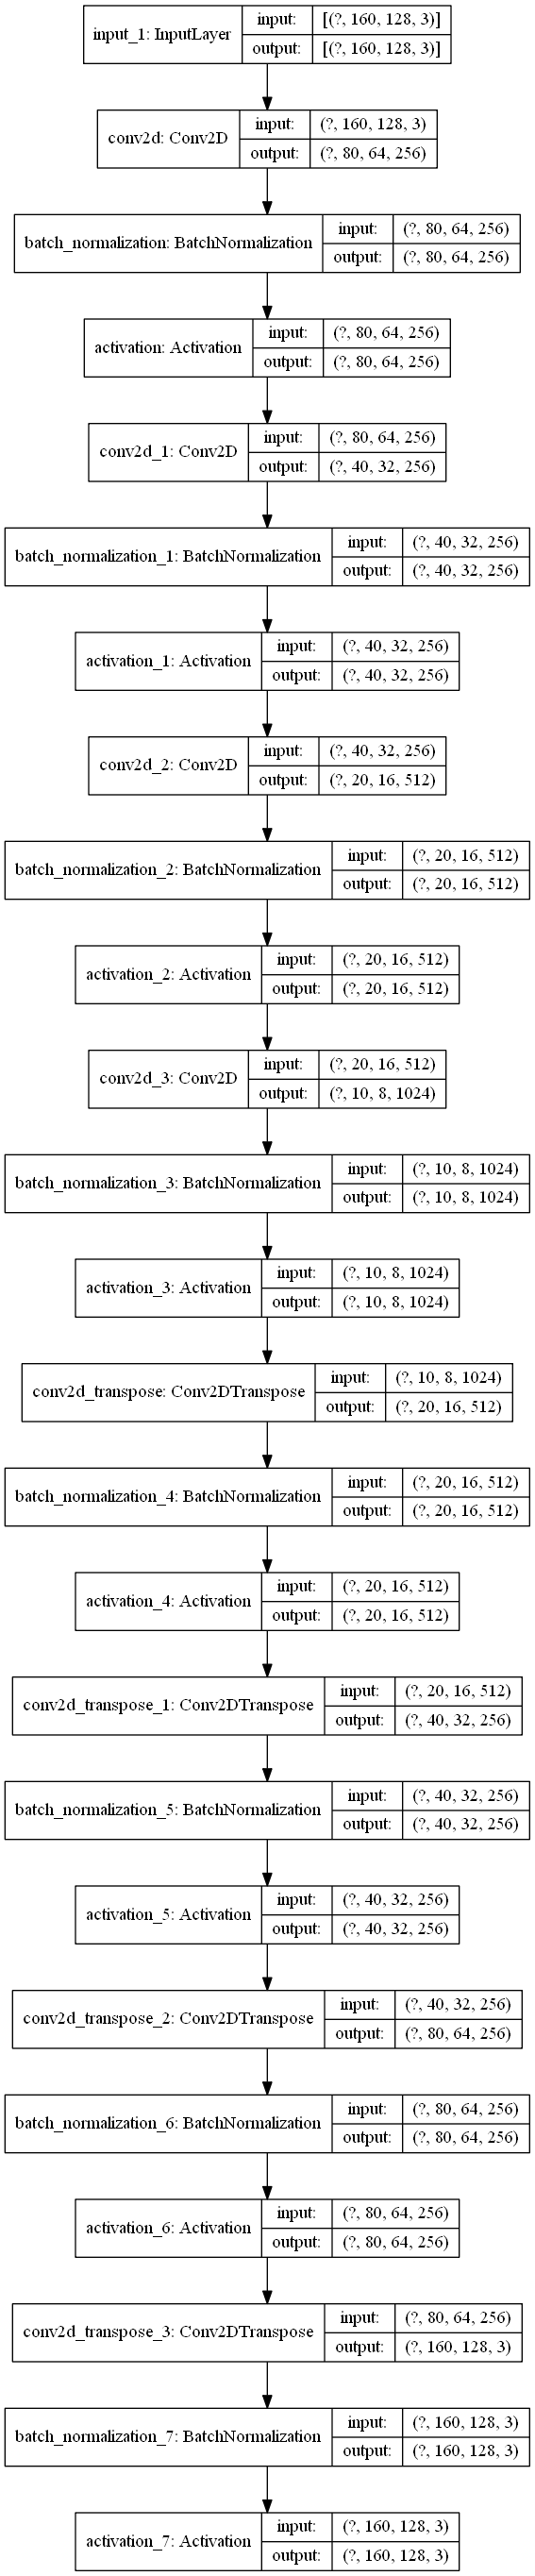

In [8]:
plot_model(generator, to_file='generator.png', show_shapes = True, show_layer_names = True)

# Modelling the Discriminator

The Discriminator has `'LeakyReLU'` activations for the Convolution part, with a `BatchNormalization` layer following every Conv layer. At the end, the output from the CNN segment was flattened and connected to a `Dense` layer with 1 node, having `'sigmoid'` as the activation function. This would enable the discrimator to predict the probability that the input image is real.

In [9]:
def make_discriminator():
    inp_disc = Input(shape = (160,128,3))
    x = Conv2D(128, kernel_size = (3,3), strides = (2,2), padding = 'same')(inp_disc)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Conv2D(256, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Conv2D(512, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Conv2D(1024, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.3)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    out_disc = Activation('sigmoid')(x)

    model = Model(inputs = inp_disc, outputs = out_disc)
    return model

In [10]:
discriminator = make_discriminator()

In [11]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 64, 128)       3584      
_________________________________________________________________
batch_normalization_8 (Batch (None, 80, 64, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 64, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 32, 256)       295168    
_________________________________________________________________
batch_normalization_9 (Batch (None, 40, 32, 256)       1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 32, 256)       0   

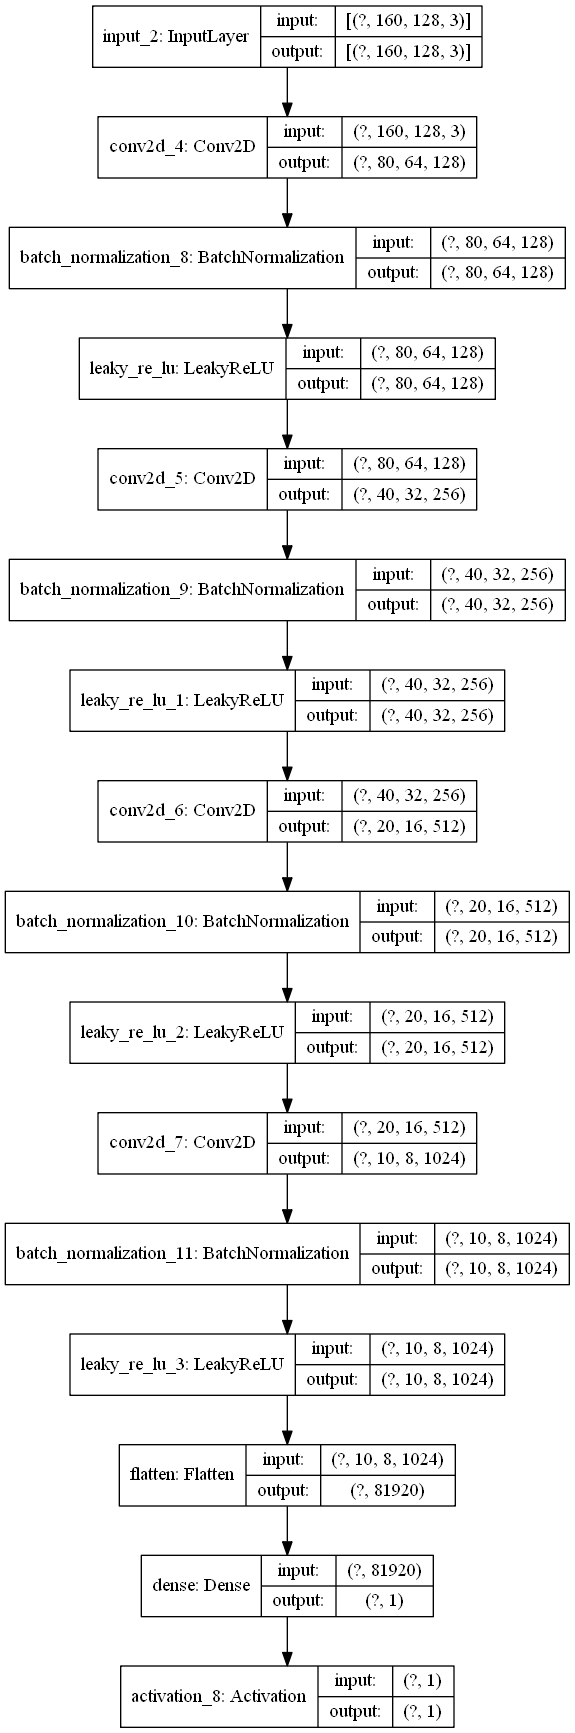

In [12]:
plot_model(discriminator, to_file='discriminator.png', show_shapes = True, show_layer_names = True)

# **The Loss Functions**

In [13]:
binary_loss = tf.keras.losses.BinaryCrossentropy()
mse_loss = tf.keras.losses.MeanSquaredError()

The job of the Discriminator is to distinguish between real images from the dataset, and those generated by the generator, i.e, when a real image is the input, it should predict `1` and when the generated image is the input, it should predict `0`. Keeping this in mind, its loss function is defined as the sum of the two binary cross entropy losses as shown below.

In [14]:
# disc_real_img_preds = Output by Discriminator for actual images from the Dataset
# disc_gen_img_preds = Output by Discriminator for images generated by the Generator

def discriminator_loss(disc_real_img_preds, disc_gen_img_preds):
    real_img_loss = binary_loss(tf.ones_like(disc_real_img_preds), disc_real_img_preds)
    gen_img_loss = binary_loss(tf.zeros_like(disc_gen_img_preds), disc_gen_img_preds)
    total_loss = real_img_loss + gen_img_loss
    return total_loss

For the generator, I used two types of losses. One is the MSE loss between the pixels of the generated image and that of the corresponding real image, and the other is the binary cross entropy loss based on the predictions of the discriminator. 

In [15]:
# real_img_batch = Batch of Actual Images from the Dataset
# gen_img_batch = Batch of Images generated by the Generator

def generator_loss(disc_gen_img_preds, real_img_batch, gen_img_batch):
    gen_img_loss = binary_loss(tf.ones_like(disc_gen_img_preds), disc_gen_img_preds)
    mse = mse_loss(real_img_batch, gen_img_batch)
    total_loss = gen_img_loss + mse

    return total_loss

# **The Optimizers**

Now, create two Adam optimizers for the generator and discriminator. Each of them will have a learning rate of 0.001.

In [16]:
gen_optim = tf.keras.optimizers.Adam(0.001)
disc_optim = tf.keras.optimizers.Adam(0.001)

# **Creating Checkpoints**

Since the training process will be quite long, Checkpoints need to be saved at regular intervals so that training can be continued later if necessary.

In [17]:
checkpoint_directory = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optim = gen_optim,
                                 disc_optim = disc_optim,
                                 generator = generator,
                                 discriminator = discriminator)

# **Patching and Noising**

Now, add distortions to the images. This is done in two ways:-
- Add random Gaussian noise.
- Add random sized Black Patches.

In [18]:
def patch_and_noise(real_imgs):
    # Shape of real_imgs is (BATCH_SIZE,160,128,3)  
    patched_imgs = np.zeros(real_imgs.shape, dtype = np.float32)
    for i in range(real_imgs.shape[0]):
        img = real_imgs[i]
        noise = np.random.randn(160,128,3) * 20      
        noise_img = img + noise
        noise_img = np.clip(noise_img,0,255)
        x = (50, 80)
        y = (50, 80)
        x1 = np.random.randint(x[0], x[1])
        x2 = np.random.randint(15, 30)
        y1 = np.random.randint(y[0], y[1])
        y2 = np.random.randint(15, 30)
        noise_img[x1:x1+x2, y1:y1+y2] = 0
        patched_imgs[i] = noise_img
    return patched_imgs

# **Standardization**

Generally, an image has pixel values in the range `0-255`. Now, before passing the images to the models, scale the images to have pixel values between `-1` and `1`. This helps in training.

In [19]:
def standardize(imgs):
    imgs = (imgs - 127.5) / 127.5
    return tf.constant(imgs)

# **De-Standardization**

The output of the generator has values between `-1` and `1`, since the activation of the output layer is `tanh`. Scale it back to the range `0` to `255`.

In [20]:
def destandardize(imgs):
    imgs = (imgs * 127.5) + 127.5
    imgs = tf.clip_by_value(imgs, clip_value_min = 0, clip_value_max = 255)
    return imgs

# Save Generated Images

This function saves the images produced by the generator, with the epoch number in its name.

In [21]:
def save_generated_images(generated_images, epoch):    
    path = './saved_imgs/'
    os.makedirs(path, exist_ok = True)
    for i in range(5):
        img = generated_images[i]
        img = img.numpy().astype('uint8')
        plt.imsave(path + "image" + str(epoch) + "_" + str(i+1) + ".jpg", img)        

# **Define Training Loop**

Now, define the `train()` and `train_step()` functions. `train_step()` will perform a `forward_pass` and calculate the gradients using `GradientTape`. `train()` will call `train_step()` for `epochs` number of times, while saving the output of the generator at regular intervals (here, every `5` step).

In [22]:
# training each batch 

#@tf.function
def train_step(real_imgs, patched_imgs):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(patched_imgs, training = True)
        disc_real_img_preds = discriminator(real_imgs, training = True)
        disc_fake_img_preds = discriminator(generated_images, training = True)

        gen_loss = generator_loss(disc_fake_img_preds, real_imgs, generated_images)
        disc_loss = discriminator_loss(disc_real_img_preds, disc_fake_img_preds)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optim.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optim.apply_gradients(zip(disc_grads, discriminator.trainable_variables))  

In [23]:
def train(img_gen, epochs, steps_per_epoch):

    for epoch in range(epochs):

        for step in tqdm(range(steps_per_epoch)):

            real_imgs = next(img_gen)
            patched_imgs = patch_and_noise(real_imgs)

            real_imgs = standardize(real_imgs)
            patched_imgs = standardize(patched_imgs)

            train_step(real_imgs, patched_imgs)

        if (epoch+1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            generated_imgs = destandardize(generator(patched_imgs, training = False))            
            save_generated_images(generated_imgs, epoch+1)
                        

        print("EPOCH {} finished".format(epoch+1))

# **Training the Model**

Now, we move on to training our `Generator` and `Discriminator`. Set the `epochs` and `steps_per_epoch` values, and call the `train()` function.

I trained the model on a GTX 1080 for about 12 days.

In [ ]:
epochs = 150
steps_per_epoch = 1000

In [ ]:
train(img_gen, epochs, steps_per_epoch)

# Loading Latest Checkpoint

Load the latest `checkpoint` in case the training got interrupted, or you need to continue training at a later time.

In [24]:
latest_ckpt = tf.train.latest_checkpoint(checkpoint_directory)
print(latest_ckpt)

./training_checkpoints\ckpt-51


In [25]:
checkpoint.restore(latest_ckpt)

# Manually Saving the Latest Checkpoint

Save the latest `checkpoint` manually in the checkpoint directory.

In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix)

# Manually Saving Generated Images

Save the output of the `Generator` manually, if necessary.

In [29]:
real_imgs = next(img_gen)
patched_imgs = patch_and_noise(real_imgs)

real_imgs = standardize(real_imgs)
patched_imgs = standardize(patched_imgs)

train_step(real_imgs, patched_imgs)

generated_imgs = destandardize(generator(patched_imgs, training = False))            
save_generated_images(generated_imgs, 1000)   # 1000 here is just a dummy number (We just want a set of generated images).

# **Looking at the Results**

Compare the Actual vs Patched vs Generated images.

In [30]:
def inference(real_imgs):
    
    #real_imgs = next(img_gen)
    patched_imgs = patch_and_noise(real_imgs)

    patched_imgs = standardize(patched_imgs)

    generated_imgs = destandardize(generator(patched_imgs, training = False))
    patched_imgs = destandardize(patched_imgs)

    fig = plt.figure(figsize = (25,15))
    #batch_size = real_imgs.shape[0]
    batch_size = 5
    

    for i in range(batch_size):
        plt.subplot(3, batch_size, i+1)
        plt.imshow(real_imgs[i].astype(int))

        plt.subplot(3, batch_size, (i+1) + batch_size)
        plt.imshow(patched_imgs[i].numpy().astype(int))

        plt.subplot(3, batch_size, (i+1) + batch_size + batch_size)
        plt.imshow(generated_imgs[i].numpy().astype(int))
    
plt.show()       

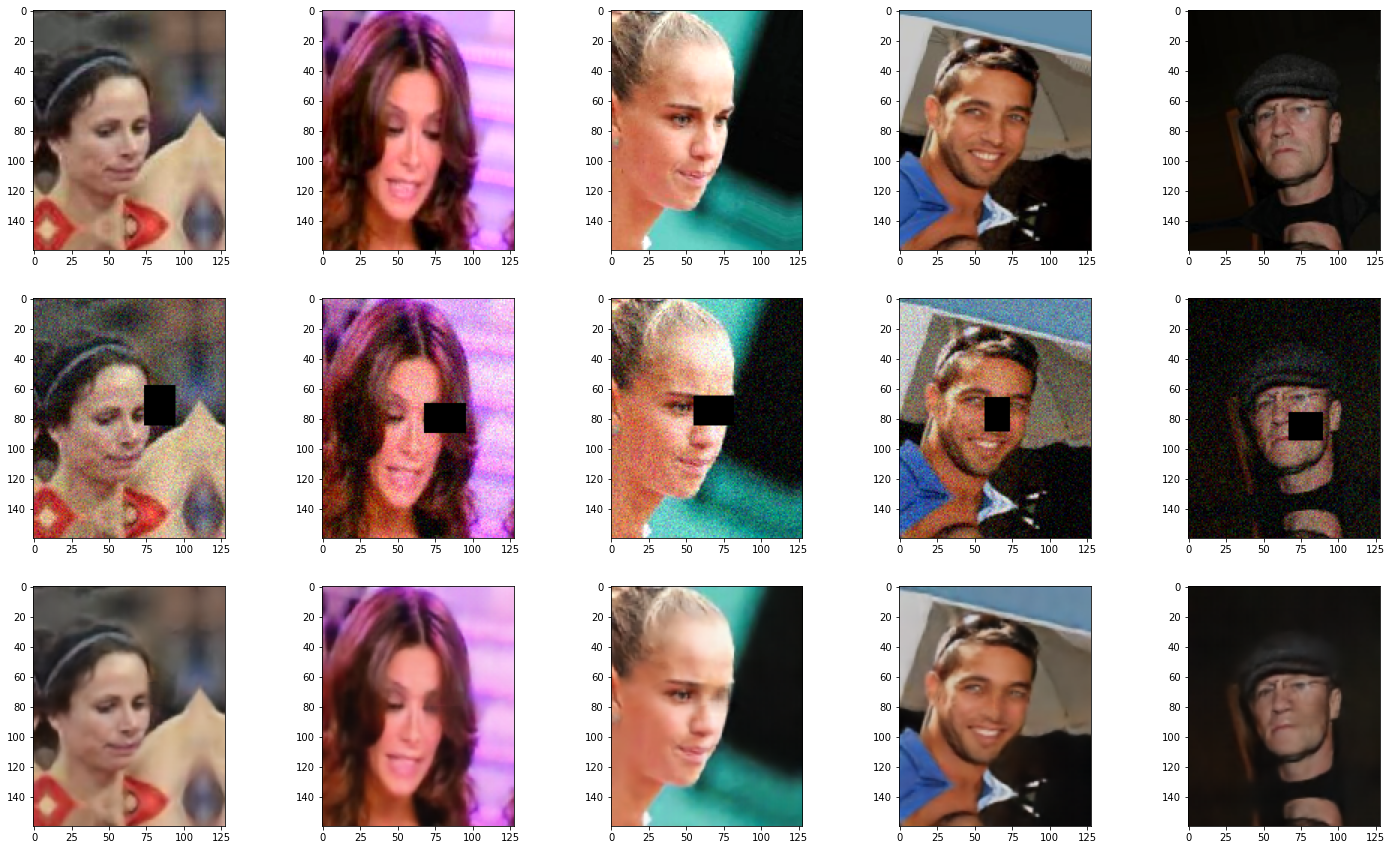

In [31]:
real_imgs = next(img_gen)
inference(real_imgs)

# Saving the Models

### Generator

In [32]:
generator.save("saved_generator")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_generator\assets


### Discriminator

In [33]:
discriminator.save("saved_discriminator")

INFO:tensorflow:Assets written to: saved_discriminator\assets


Quite evidently, the model struggles to generate complex features like eyes and mouths. Further improvement can be done by training the model further and exploring different architectures for the generator. 

An autoencoder is made up of an encoder and a decoder. The encoder creates a very dense encoding, which is passed into the decoder so that it can generate an output from it. An inherent flaw with this architecture is that there is a lot of information loss. Forcing the image data to pass through a bottleneck removes minor and semi-minor features and keeps only the most prominent ones. However, these removed features might have been useful to the decoder for proper regeneration of the image.

Further, GANs are difficult and slow to train, mainly because initially, neither the generator and the discriminator has proper knowledge about the dataset and their jobs, as a result of which, they need some time to produce stable outputs.

# References

- https://www.cc.gatech.edu/~hays/7476/projects/Avery_Wenchen/
- https://www.tensorflow.org/tutorials/generative/dcgan
- https://arxiv.org/abs/1406.2661